In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
from PIL import Image
import cv2
import os
from sklearn.model_selection import train_test_split 
from keras.models import Sequential
from keras.layers import Conv2D, MaxPool2D, Dense, Flatten, Dropout
import matplotlib.pyplot as plt
import plotly.express as px
import random
from keras.losses import SparseCategoricalCrossentropy
from collections import Counter

In [2]:
def is_blurry(image, threshold=100):
    gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    variance = cv2.Laplacian(gray_image, cv2.CV_64F).var()
    return variance < threshold

def sharpen_image(image):
    kernel = np.array([
        [-1, -1, -1],
        [-1,  9, -1],
        [-1, -1, -1]
    ])
    sharpened = cv2.filter2D(image, -1, kernel)
    return sharpened

In [3]:
import cv2
import numpy as np
from PIL import ImageEnhance

def enhance_dark_image(image):
    """
    Enhance images that are too dark using adaptive histogram equalization and brightness adjustment,
    with noise reduction to avoid amplifying noise.
    """
    gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    mean_brightness = np.mean(gray)

    if mean_brightness < 60: 
        image = cv2.GaussianBlur(image, (5, 5), 0)

        clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
        image_lab = cv2.cvtColor(image, cv2.COLOR_RGB2LAB)
        l, a, b = cv2.split(image_lab)

        l = clahe.apply(l)
        enhanced_image_lab = cv2.merge((l, a, b))
        image = cv2.cvtColor(enhanced_image_lab, cv2.COLOR_LAB2RGB)

        pil_image = Image.fromarray(image)
        enhancer = ImageEnhance.Brightness(pil_image)
        brightness_factor = 1 + (60 - mean_brightness) / 100.0  
        image = np.array(enhancer.enhance(brightness_factor)) 

    return image

Image 00000_00002_00000_png.rf.3f5868e97a26b188b4d3ce823c6e9c2f.jpg is blurry, sharpening...
Image 00000_00002_00001_png.rf.3cef739224527428e387081193bd420b.jpg is blurry, sharpening...
Image 00000_00002_00001_png.rf.b3a05eda45b885ae1a472c7547721760.jpg is blurry, sharpening...
Image 00000_00002_00002_png.rf.02a1b30e881b936472e3872b5e7cf3b0.jpg is blurry, sharpening...
Image 00000_00002_00002_png.rf.2df6f5515035d2e03ba24ec9e622753a.jpg is blurry, sharpening...
Image 00000_00002_00003_png.rf.98523532781dd4a1df08bbddeef993ad.jpg is blurry, sharpening...
Image 00000_00002_00003_png.rf.dbd1e2336ba48e0575fb5b91b48e6af8.jpg is blurry, sharpening...
Image 00000_00002_00004_png.rf.42fa00c6a4d5575600e9de72a47bb7a4.jpg is blurry, sharpening...
Image 00000_00002_00004_png.rf.a628aaae48b8d9635585e79879bd2788.jpg is blurry, sharpening...
Image 00000_00002_00005_png.rf.4a27eb57929561fce8d7295d6e5a02d4.jpg is blurry, sharpening...
Image 00000_00002_00006_png.rf.5cf10a07acd232b133e564cc9f0b058b.jpg is

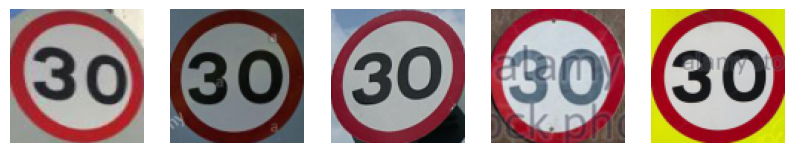

In [4]:
def fetch_image_with_detection_and_visualization(data_folder):
    """
    Fetch images and corresponding labels, perform detection (crop based on bounding boxes),
    and resize to fit the classifier's input. Also visualizes a sample cropped image.
    """
    train_data = []
    test_data = []
    valid_data = []
    cropped_samples = [] 

    splits = {
        "train": os.path.join(data_folder, "train"),
        "test": os.path.join(data_folder, "test"),
        "valid": os.path.join(data_folder, "valid")
    }

    for split_name, split_path in splits.items():
        images_folder = os.path.join(split_path, "images")
        labels_folder = os.path.join(split_path, "labels")

        for image_name in os.listdir(images_folder):
            label_name = os.path.splitext(image_name)[0] + ".txt"
            label_path = os.path.join(labels_folder, label_name)
            image_path = os.path.join(images_folder, image_name)

            if not os.path.exists(label_path):
                print(f"Warning: Label file not found for {image_name}")
                continue

            img = Image.open(image_path)
            image_width, image_height = img.size
            img = np.array(img)
            
            img = enhance_dark_image(img)

            if is_blurry(img):
                print(f"Image {image_name} is blurry, sharpening...")
                img = sharpen_image(img)

            with open(label_path, "r") as label_file:
                lines = label_file.readlines()
                for line in lines:
                    parts = line.strip().split()
                    class_id = int(parts[0]) 

                    x_center, y_center, width, height = map(float, parts[1:])

                    x_min = int((x_center - width / 2) * image_width)
                    y_min = int((y_center - height / 2) * image_height)
                    x_max = int((x_center + width / 2) * image_width)
                    y_max = int((y_center + height / 2) * image_height)

                    cropped_img = img[y_min:y_max, x_min:x_max]

                    resized_img = cv2.resize(cropped_img, (90, 90), interpolation=cv2.INTER_AREA)

                    resized_img = resized_img / 255.0

                    if len(cropped_samples) < 5: 
                        cropped_samples.append(resized_img)

                    if split_name == "train":
                        train_data.append((resized_img, class_id))
                    elif split_name == "test":
                        test_data.append((resized_img, class_id))
                    elif split_name == "valid":
                        valid_data.append((resized_img, class_id))

    if cropped_samples:
        plt.figure(figsize=(10, 10))
        for i, cropped_img in enumerate(cropped_samples):
            plt.subplot(1, len(cropped_samples), i+1)
            plt.imshow(cropped_img)
            plt.axis('off')
        plt.show()

    return train_data, test_data, valid_data
data_folder = "./DataSet"
train_data, test_data, valid_data = fetch_image_with_detection_and_visualization(data_folder)

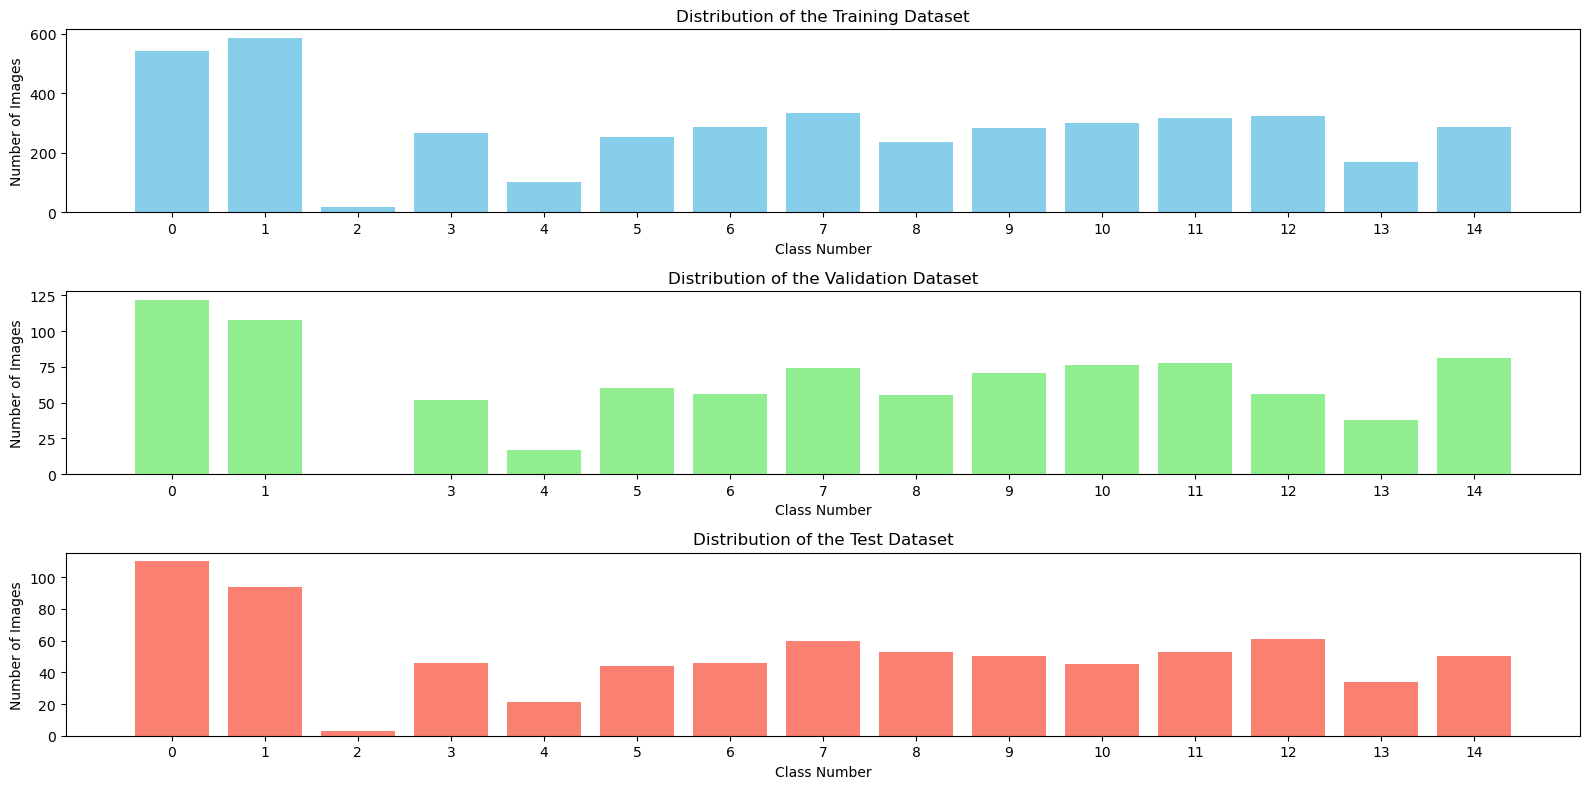

In [5]:
train_class_counts = Counter(class_id for _, class_id in train_data)
valid_class_counts = Counter(class_id for _, class_id in valid_data)
test_class_counts = Counter(class_id for _, class_id in test_data)

train_classes, train_num_of_samples = zip(*sorted(train_class_counts.items()))
valid_classes, valid_num_of_samples = zip(*sorted(valid_class_counts.items()))
test_classes, test_num_of_samples = zip(*sorted(test_class_counts.items()))

plt.figure(figsize=(16, 8))

plt.subplot(3, 1, 1)
plt.bar(train_classes, train_num_of_samples, color='skyblue')
plt.title("Distribution of the Training Dataset")
plt.xlabel("Class Number")
plt.ylabel("Number of Images")
plt.xticks(train_classes)

plt.subplot(3, 1, 2)
plt.bar(valid_classes, valid_num_of_samples, color='lightgreen')
plt.title("Distribution of the Validation Dataset")
plt.xlabel("Class Number")
plt.ylabel("Number of Images")
plt.xticks(valid_classes)

plt.subplot(3, 1, 3)
plt.bar(test_classes, test_num_of_samples, color='salmon')
plt.title("Distribution of the Test Dataset")
plt.xlabel("Class Number")
plt.ylabel("Number of Images")
plt.xticks(test_classes)

plt.tight_layout()
plt.show()

In [6]:
training_data_features, training_data_labels = zip(*train_data)
training_data_features = np.array(training_data_features).reshape(-1, 90, 90, 3)  # Add channel dimension
training_data_labels = np.array(training_data_labels)

validation_data_features, validation_data_labels = zip(*valid_data)
validation_data_features = np.array(validation_data_features).reshape(-1, 90, 90, 3)
validation_data_labels = np.array(validation_data_labels)

test_data_features, test_data_labels = zip(*test_data)
test_data_features = np.array(test_data_features).reshape(-1, 90, 90, 3)
test_data_labels = np.array(test_data_labels)

In [7]:
print(f"Training data features shape: {np.array(training_data_features).shape}")
print(f"Training data labels shape: {np.array(training_data_labels).shape}")

Training data features shape: (4298, 90, 90, 3)
Training data labels shape: (4298,)


In [8]:
unique_labels, label_counts = np.unique(training_data_labels, return_counts=True)
for label, count in zip(unique_labels, label_counts):
    print(f"Label {label}: {count} occurrences")

Label 0: 542 occurrences
Label 1: 585 occurrences
Label 2: 19 occurrences
Label 3: 267 occurrences
Label 4: 101 occurrences
Label 5: 252 occurrences
Label 6: 285 occurrences
Label 7: 334 occurrences
Label 8: 235 occurrences
Label 9: 283 occurrences
Label 10: 301 occurrences
Label 11: 318 occurrences
Label 12: 323 occurrences
Label 13: 168 occurrences
Label 14: 285 occurrences


In [9]:
cnnModel = Sequential()
cnnModel.add(Conv2D(16,(3,3), padding="same", input_shape=(90, 90, 3), activation='relu'))
print(cnnModel(training_data_features).shape)
cnnModel.add(MaxPool2D((2,2), strides=None, padding="same"))
cnnModel.add(Conv2D(32,(3,3), padding="same", activation='relu'))
cnnModel.add(MaxPool2D((2,2), strides=None, padding="same"))
cnnModel.add(Conv2D(64,(5,5), padding="same", activation='relu'))
cnnModel.add(MaxPool2D((2,2), strides=None, padding="same"))
cnnModel.add(Conv2D(128,(7,7), padding="same", activation='relu'))
cnnModel.add(MaxPool2D((2,2), strides=None, padding="same"))
cnnModel.add(Flatten())
cnnModel.add(Dense(232, activation='relu'))
cnnModel.add(Dense(116, activation='relu'))
cnnModel.add(Dense(15, activation='softmax'))

C:\Users\manou\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


(4298, 90, 90, 16)


In [10]:
cnnModel.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 90, 90, 16)          │             448 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 45, 45, 16)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 45, 45, 32)          │           4,640 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 23, 23, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 23, 23, 64)          │          51,264 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 12, 12, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 12, 12, 128)         │         401,536 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 6, 6, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 4608)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 232)                 │       1,069,288 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 116)                 │          27,028 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 15)                  │           1,755 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,555,959 (5.94 MB)

 Trainable params: 1,555,959 (5.94 MB)

 Non-trainable params: 0 (0.00 B)

In [11]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Define the data augmentation
datagen = ImageDataGenerator(
    shear_range=0.2,
    zoom_range=0.1,
    rotation_range=45, 
    horizontal_flip=False,
    vertical_flip=False
)

# Fit the generator
datagen.fit(training_data_features)

In [12]:
cnnModel.compile(optimizer='adam', loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), metrics=['accuracy'])

In [13]:
SignTraffic = cnnModel.fit(
    datagen.flow(training_data_features, training_data_labels, batch_size=32),
    validation_data=(validation_data_features, validation_data_labels),
    epochs=20
)

C:\Users\manou\AppData\Roaming\Python\Python312\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/20


C:\Users\manou\AppData\Roaming\Python\Python312\site-packages\keras\src\backend\tensorflow\nn.py:678: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


135/135 ━━━━━━━━━━━━━━━━━━━━ 18s 109ms/step - accuracy: 0.2085 - loss: 2.3850 - val_accuracy: 0.3824 - val_loss: 1.7329
Epoch 2/20
135/135 ━━━━━━━━━━━━━━━━━━━━ 20s 149ms/step - accuracy: 0.3913 - loss: 1.7471 - val_accuracy: 0.4672 - val_loss: 1.6116
Epoch 3/20
135/135 ━━━━━━━━━━━━━━━━━━━━ 12s 92ms/step - accuracy: 0.4221 - loss: 1.6348 - val_accuracy: 0.4460 - val_loss: 1.5445
Epoch 4/20
135/135 ━━━━━━━━━━━━━━━━━━━━ 13s 99ms/step - accuracy: 0.4529 - loss: 1.5895 - val_accuracy: 0.4926 - val_loss: 1.4329
Epoch 5/20
135/135 ━━━━━━━━━━━━━━━━━━━━ 13s 99ms/step - accuracy: 0.4993 - loss: 1.4352 - val_accuracy: 0.6451 - val_loss: 0.9587
Epoch 6/20
135/135 ━━━━━━━━━━━━━━━━━━━━ 13s 98ms/step - accuracy: 0.6805 - loss: 0.9261 - val_accuracy: 0.8475 - val_loss: 0.4909
Epoch 7/20
135/135 ━━━━━━━━━━━━━━━━━━━━ 12s 88ms/step - accuracy: 0.8169 - loss: 0.5783 - val_accuracy: 0.8697 - val_loss: 0.3960
Epoch 8/20
135/135 ━━━━━━━━━━━━━━━━━━━━ 13s 99ms/step - accuracy: 0.8618 - loss: 0.4382 - val_accur

<Axes: >

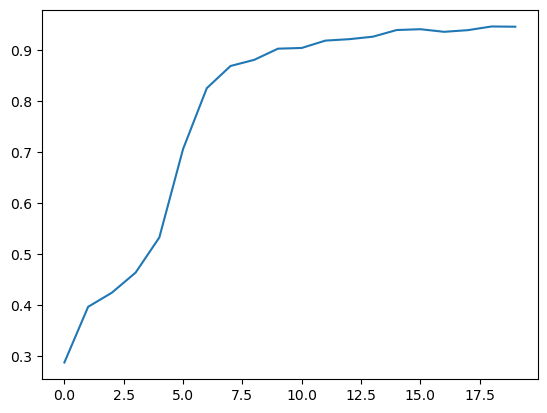

In [14]:
import seaborn as sns
sns.lineplot(SignTraffic.history['accuracy'])

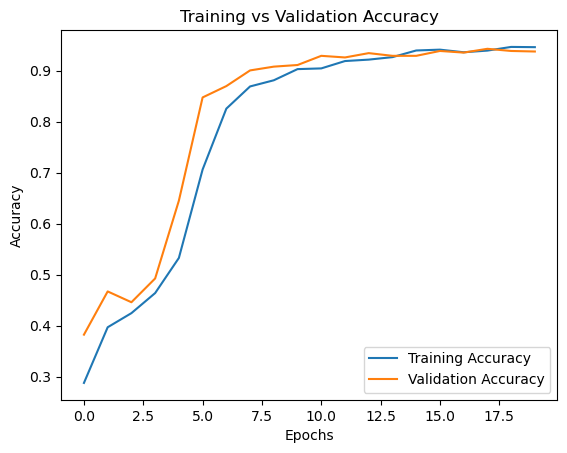

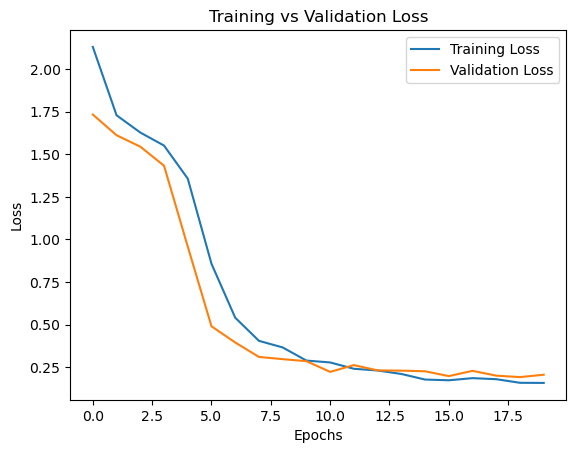

In [15]:
import matplotlib.pyplot as plt
# Assuming history is the result of the model's fit() method
plt.plot(SignTraffic.history['accuracy'], label='Training Accuracy')
plt.plot(SignTraffic.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training vs Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

plt.plot(SignTraffic.history['loss'], label='Training Loss')
plt.plot(SignTraffic.history['val_loss'], label='Validation Loss')
plt.title('Training vs Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step


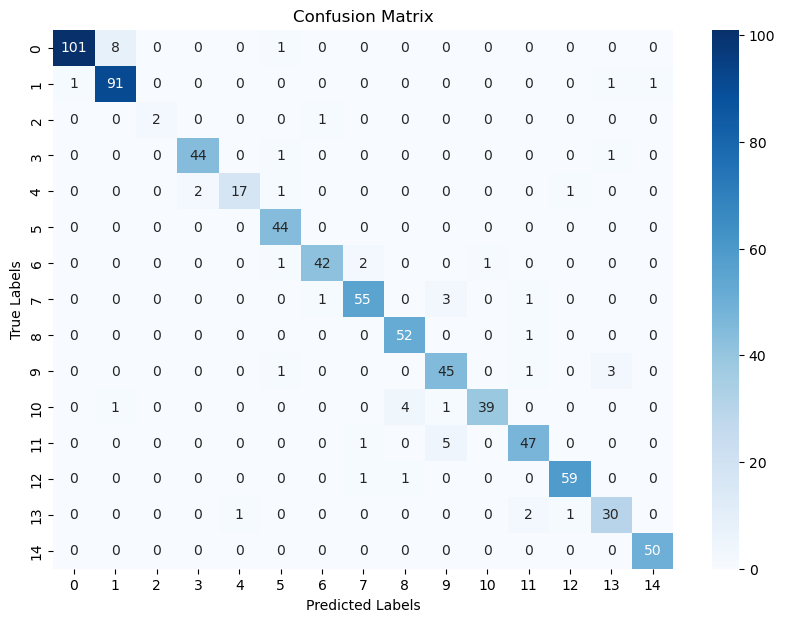

In [16]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

test_predictions = cnnModel.predict(test_data_features)
test_predictions = np.argmax(test_predictions, axis=1)

cm = confusion_matrix(test_data_labels, test_predictions)

# Plot the confusion matrix
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=np.unique(test_data_labels), yticklabels=np.unique(test_data_labels))
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

In [17]:
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score

# Calculate metrics for each class
for i in range(cm.shape[0]):
    tp = cm[i, i]
    fp = cm[:, i].sum() - tp  
    fn = cm[i, :].sum() - tp 
    tn = cm.sum() - (tp + fp + fn)
    
    precision = tp / (tp + fp) if (tp + fp) != 0 else 0
    recall = tp / (tp + fn) if (tp + fn) != 0 else 0
    f1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) != 0 else 0
    accuracy = (tp + tn) / (tp + tn + fp + fn)
    
    print(f"Class {i}:")
    print(f"True Positive (TP): {tp}")
    print(f"False Positive (FP): {fp}")
    print(f"False Negative (FN): {fn}")
    print(f"True Negative (TN): {tn}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1-Score: {f1:.4f}")
    print(f"Accuracy: {accuracy:.4f}")
    print()


Class 0:
True Positive (TP): 101
False Positive (FP): 1
False Negative (FN): 9
True Negative (TN): 659
Precision: 0.9902
Recall: 0.9182
F1-Score: 0.9528
Accuracy: 0.9870

Class 1:
True Positive (TP): 91
False Positive (FP): 9
False Negative (FN): 3
True Negative (TN): 667
Precision: 0.9100
Recall: 0.9681
F1-Score: 0.9381
Accuracy: 0.9844

Class 2:
True Positive (TP): 2
False Positive (FP): 0
False Negative (FN): 1
True Negative (TN): 767
Precision: 1.0000
Recall: 0.6667
F1-Score: 0.8000
Accuracy: 0.9987

Class 3:
True Positive (TP): 44
False Positive (FP): 2
False Negative (FN): 2
True Negative (TN): 722
Precision: 0.9565
Recall: 0.9565
F1-Score: 0.9565
Accuracy: 0.9948

Class 4:
True Positive (TP): 17
False Positive (FP): 1
False Negative (FN): 4
True Negative (TN): 748
Precision: 0.9444
Recall: 0.8095
F1-Score: 0.8718
Accuracy: 0.9935

Class 5:
True Positive (TP): 44
False Positive (FP): 5
False Negative (FN): 0
True Negative (TN): 721
Precision: 0.8980
Recall: 1.0000
F1-Score: 0.946

In [18]:
from sklearn.metrics import classification_report
print(classification_report(test_data_labels, test_predictions))

              precision    recall  f1-score   support

           0       0.99      0.92      0.95       110
           1       0.91      0.97      0.94        94
           2       1.00      0.67      0.80         3
           3       0.96      0.96      0.96        46
           4       0.94      0.81      0.87        21
           5       0.90      1.00      0.95        44
           6       0.95      0.91      0.93        46
           7       0.93      0.92      0.92        60
           8       0.91      0.98      0.95        53
           9       0.83      0.90      0.87        50
          10       0.97      0.87      0.92        45
          11       0.90      0.89      0.90        53
          12       0.97      0.97      0.97        61
          13       0.86      0.88      0.87        34
          14       0.98      1.00      0.99        50

    accuracy                           0.93       770
   macro avg       0.93      0.91      0.92       770
weighted avg       0.93   

In [19]:
cnnModel.save("models/model.keras")

In [20]:
from PIL import Image
import numpy as np

def preprocess_image(image_path):
    img = Image.open(image_path)
    print(f"Original Image Size: {img.size}")
    img = img.resize((90, 90))
    img_array = np.array(img)
    if len(img_array.shape) == 2: 
        img_array = np.stack([img_array] * 3, axis=-1)
    
    img_array = img_array / 255.0
    img_array = img_array.reshape(-1, 90, 90, 3)
    print(f"Image Resize: {img_array.shape}")
    return img_array

In [21]:
def predict_image(image_path, model):
    img_array = preprocess_image(image_path)   
    predictions = model.predict(img_array)
    predicted_class = np.argmax(predictions, axis=1)[0]
    predicted_probability = np.max(predictions, axis=1)[0]
    return predicted_class, predicted_probability

Original Image Size: (217, 237)
Image Resize: (1, 90, 90, 3)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
Predicted Class: 8
Prediction Probability: 0.9997


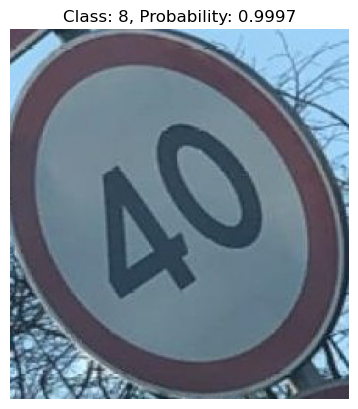

In [22]:
# Example usage
test_path = r"test_img\40_louta_2.jpg" 
expected_size=(90, 90)
predicted_class, predicted_probability = predict_image(test_path, cnnModel)
print(f"Predicted Class: {predicted_class}")
print(f"Prediction Probability: {predicted_probability:.4f}")
img = Image.open(test_path)
plt.imshow(img)
plt.axis('off')  
plt.title(f"Class: {predicted_class}, Probability: {predicted_probability:.4f}")
plt.show()